<a href="https://colab.research.google.com/github/usmaan275/CNN/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda


100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


Epoch 1/100
Train Loss: 1.6250, Train Accuracy: 40.37%
Test Loss: 1.4601, Test Accuracy: 47.75%
Epoch 2/100
Train Loss: 1.3406, Train Accuracy: 51.85%
Test Loss: 1.5080, Test Accuracy: 45.31%
Epoch 3/100
Train Loss: 1.2408, Train Accuracy: 55.62%
Test Loss: 1.2387, Test Accuracy: 55.59%
Epoch 4/100
Train Loss: 1.1661, Train Accuracy: 58.49%
Test Loss: 1.3299, Test Accuracy: 54.20%
Epoch 5/100
Train Loss: 1.1211, Train Accuracy: 60.08%
Test Loss: 1.3153, Test Accuracy: 52.80%
Epoch 6/100
Train Loss: 1.0806, Train Accuracy: 61.71%
Test Loss: 1.1217, Test Accuracy: 60.32%
Epoch 7/100
Train Loss: 1.0432, Train Accuracy: 63.13%
Test Loss: 1.3799, Test Accuracy: 51.00%
Epoch 8/100
Train Loss: 1.0149, Train Accuracy: 64.11%
Test Loss: 1.0589, Test Accuracy: 62.31%
Epoch 9/100
Train Loss: 0.9874, Train Accuracy: 64.94%
Test Loss: 1.1806, Test Accuracy: 59.40%
Epoch 10/100
Train Loss: 0.9658, Train Accuracy: 65.97%
Test Loss: 1.4387, Test Accuracy: 54.01%
Epoch 11/100
Train Loss: 0.9457, Train 

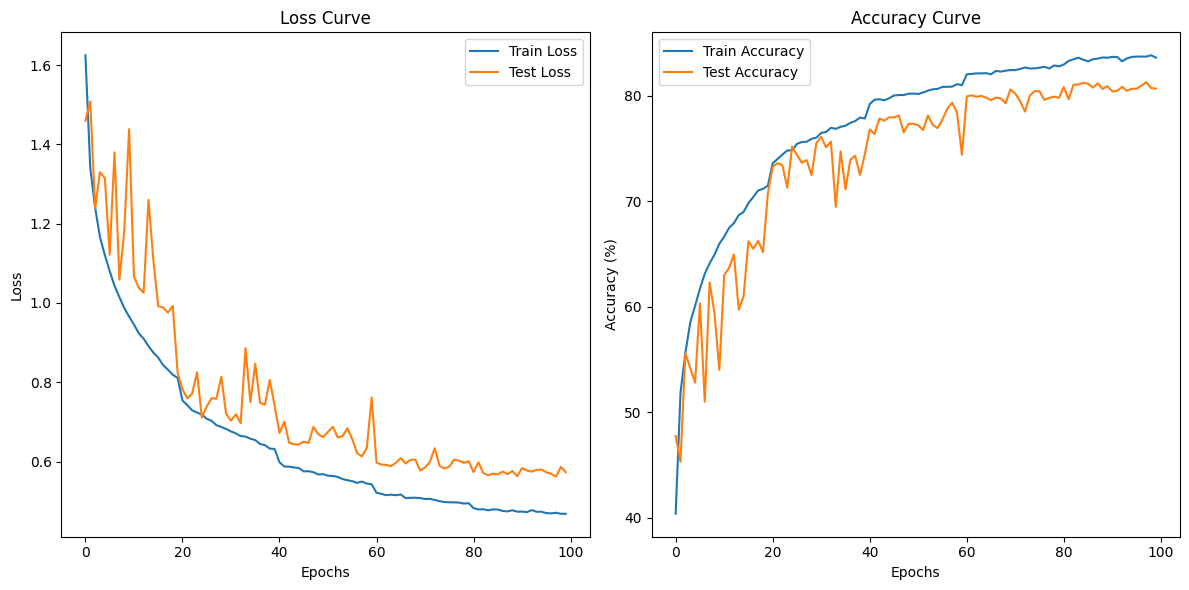

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

# ----- Expert Branch -----
class ExpertBranch(nn.Module):
    def __init__(self, in_channels, reduction_ratio, num_experts):
        super(ExpertBranch, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction_ratio)
        self.fc2 = nn.Linear(in_channels // reduction_ratio, num_experts)

    def forward(self, x):
        batch_size = x.size(0)
        pooled = self.pool(x).view(batch_size, -1)  # [B, C]
        a = F.relu(self.fc1(pooled))
        a = self.fc2(a)
        a = F.softmax(a, dim=1)
        return a

# ----- Expert Block -----
class ExpertBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_experts=4, reduction_ratio=4):
        super(ExpertBlock, self).__init__()
        self.num_experts = num_experts
        self.expert_branch = ExpertBranch(in_channels, reduction_ratio, num_experts)

        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            ) for _ in range(num_experts)
        ])

    def forward(self, x):
        a = self.expert_branch(x)  # shape: [B, K]
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=1)  # [B, K, C, H, W]
        a = a.view(a.size(0), self.num_experts, 1, 1, 1)
        out = (a * expert_outputs).sum(dim=1)  # Weighted sum over experts
        return out

# ----- Custom CNN -----
class CustomCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomCNN, self).__init__()

        # --- Stem ---
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # --- Backbone ---
        self.backbone = nn.Sequential(
            ExpertBlock(64, 128, num_experts=4),
            ExpertBlock(128, 128, num_experts=4)  # Reduced to 2 expert blocks
        )

        # --- Classifier ---
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.2),  # Added dropout for regularization
            nn.Linear(128, num_classes)  # Update input size for last layer if more channels
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.backbone(x)
        x = self.classifier(x)
        return x

# ----- Training and Evaluation -----

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = 100 * correct_preds / total_preds
    return avg_loss, accuracy

def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct_preds / total_preds
    return avg_loss, accuracy

# ----- Training Loop and Plotting -----
def train_model(model, train_loader, test_loader, epochs, learning_rate=0.001, device='cuda'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
        test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

        scheduler.step()

    # Plotting results
    plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies)

def plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies):
    epochs = len(train_losses)

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label='Train Loss')
    plt.plot(range(epochs), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(epochs), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy Curve')

    plt.tight_layout()
    plt.show()

# Clear GPU memory and synchronize
torch.cuda.empty_cache()
torch.cuda.synchronize()

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transforms (same for train and test, but you can tweak this)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=100, shuffle=False, num_workers=2)

# Initialize model (assuming you have CustomCNN defined somewhere above)
model = CustomCNN(num_classes=10).to(device)

# Train the model
epochs = 100
learning_rate = 0.001
train_model(model, train_loader, test_loader, epochs, learning_rate, device)
